In [2]:
import zipfile
import os

# Path to the uploaded zip file
zip_file = '/content/smallset.zip'

# Define the output directory where you want to extract the contents
output_dir = '/content/lung_image_sets_extracted'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Folder extracted to {output_dir}")

# Check the extracted contents
extracted_files = os.listdir(output_dir)
print("Extracted files and folders:", extracted_files)

# Optionally, check contents of each subfolder
for subfolder in extracted_files:
    subfolder_path = os.path.join(output_dir, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Contents of {subfolder}:")
        print(os.listdir(subfolder_path))


Folder extracted to /content/lung_image_sets_extracted
Extracted files and folders: ['smallset']
Contents of smallset:
['no', 'yes']


In [3]:
import os
import pandas as pd

# Define the base path to the extracted dataset
base_path = '/content/lung_image_sets_extracted/smallset/'  # Adjust this if needed

# Define the categories and their one-hot encoded labels
categories = {
    "no": [1, 0],  # Non-cancerous
    "yes": [0, 1],  # Cancerous

}

# List to store the data
data = []

# Iterate through the folders and collect file paths with labels
for category, one_hot_label in categories.items():
    folder_path = os.path.join(base_path, category)

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Warning: Folder '{folder_path}' does not exist. Skipping...")
        continue

    # Iterate through the image files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
            file_path = os.path.join(folder_path, filename)
            data.append({"image_path": file_path, "label": one_hot_label})

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame to check data before saving
print("Data preview:")
print(df.head())

# Save the dataset to a CSV file
output_file = '/content/lung_dataset_one_hot.csv'  # Adjust the path if needed
df.to_csv(output_file, index=False)

print(f"Dataset created successfully and saved as '{output_file}'.")


Data preview:
                                          image_path   label
0  /content/lung_image_sets_extracted/smallset/no...  [1, 0]
1  /content/lung_image_sets_extracted/smallset/no...  [1, 0]
2  /content/lung_image_sets_extracted/smallset/no...  [1, 0]
3  /content/lung_image_sets_extracted/smallset/no...  [1, 0]
4  /content/lung_image_sets_extracted/smallset/no...  [1, 0]
Dataset created successfully and saved as '/content/lung_dataset_one_hot.csv'.


In [4]:
import pandas as pd

# Load the dataset
csv_file = '/content/lung_dataset_one_hot.csv'  # Adjust path if needed
df = pd.read_csv(csv_file)

# Count the occurrences of non-cancerous and cancerous labels
non_cancerous_count = df['label'].apply(lambda x: x == '[1, 0]').sum()  # Count non-cancerous
cancerous_count = df['label'].apply(lambda x: x == '[0, 1]').sum()  # Count cancerous

# Print the counts
print(f"Non-cancerous count: {non_cancerous_count}")
print(f"Cancerous count: {cancerous_count}")


Non-cancerous count: 144
Cancerous count: 144


In [5]:
import pandas as pd
from PIL import Image

# Load the dataset
csv_file = '/content/lung_dataset_one_hot.csv'  # Adjust path if needed
df = pd.read_csv(csv_file)

# Get the first image path
first_image_path = df['image_path'].iloc[1]  # Adjust index as needed

# Open the image
image = Image.open(first_image_path)

# Get the dimensions (width, height)
width, height = image.size

# Print the dimensions
print(f"Image Dimensions for {first_image_path}: Width = {width}, Height = {height}")


Image Dimensions for /content/lung_image_sets_extracted/smallset/no/lungn143.jpeg: Width = 768, Height = 768


In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image


In [7]:
# Load the CSV data
csv_path = '/content/lung_dataset_one_hot.csv'  # Change to the path where your CSV is saved
df = pd.read_csv(csv_path)

# Load image paths and labels
image_paths = df['image_path'].values
labels = np.array(df['label'].apply(eval).tolist())  # Convert string representation of list to actual list

# Function to load and preprocess images (no resizing)
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # No resizing, use original size
    img = tf.cast(img, tf.float32)  # Convert to float32 for normalization
    img = img / 255.0  # Normalize to [0, 1]
    return img


# Load all images and labels
images = np.array([load_and_preprocess_image(img_path) for img_path in image_paths])
labels = np.array(labels)

# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
X_train.shape

(230, 768, 768, 3)

In [9]:

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.optimizers import Adam
from keras.models import Model

In [10]:
from tensorflow.keras import layers, Model

def define_model():
    inputs = layers.Input(shape=(768, 768, 3))  # Input layer

    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # Add Multi-Head Attention Layer
    # Note: Attention layers generally require sequences, so you will need to reshape your feature maps into a sequence-like shape
    x = layers.Reshape((-1, 128))(x)  # Flatten spatial dimensions, leaving the channel dimension as is
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)  # Multi-head attention

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=x)
    return model

mobile = define_model()


In [11]:
op_layer = mobile.output  # Output of the `mobile` model

# Add custom dense layers
final_layer = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(op_layer)
final_layer = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(final_layer)
final_layer = layers.Dense(2, )(final_layer)

# Define the final model using the Functional API
model = Model(inputs=mobile.input, outputs=final_layer)

# Compile the model
optimizer_sgd = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 768, 768, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 768, 768, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 768, 768, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 768, 768, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 768, 768, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 384, 384, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 384, 384, 32)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 384, 384, 64)   │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 384, 384, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 384, 384, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 384, 384, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 192, 192, 64)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 192, 192, 64)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 192, 192, 128)  │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 192, 192, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 192, 192, 128)  │        147,584 │ batch_normalization_4… │
├──────────────────────

 Total params: 10,385,410 (39.62 MB)

 Trainable params: 10,383,234 (39.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001),  # Changed this line
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


# Assuming you have the training and validation datasets defined (e.g., train_dataset, val_dataset)
# Here's how you would train the model

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[

        tf.keras.callbacks.ModelCheckpoint("classification_deep_conv_model.keras", save_best_only=True)
    ]
)



Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9784 - loss: 0.0985 - val_accuracy: 0.7069 - val_loss: 1.2089
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 486ms/step - accuracy: 0.9869 - loss: 0.0251 - val_accuracy: 0.8621 - val_loss: 0.2382
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step - accuracy: 0.9974 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step - accuracy: 0.9798 - loss: 0.0921 - val_accuracy: 0.9828 - val_loss: 0.0477
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9996 - loss: 0.0049 - val_accuracy: 0.9655 - val_loss: 0.1588
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 474ms/step - accuracy: 0.9720 - loss: 0.3600 - val_accuracy: 0.8276 - val_loss: 0.5302
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - accuracy: 0.9418 - loss: 0.2099 - val_accuracy: 0.6897 - val_loss: 0.7847
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - accuracy: 0.9269 - loss: 0.2738 - val

In [14]:
# Exclude the first 10 epochs from history
accuracy_values = history.history['accuracy']


avg_train_accuracy = np.mean(accuracy_values)
print(f"Average Training Accuracy : {avg_train_accuracy:.4f}")


Average Training Accuracy : 0.9736


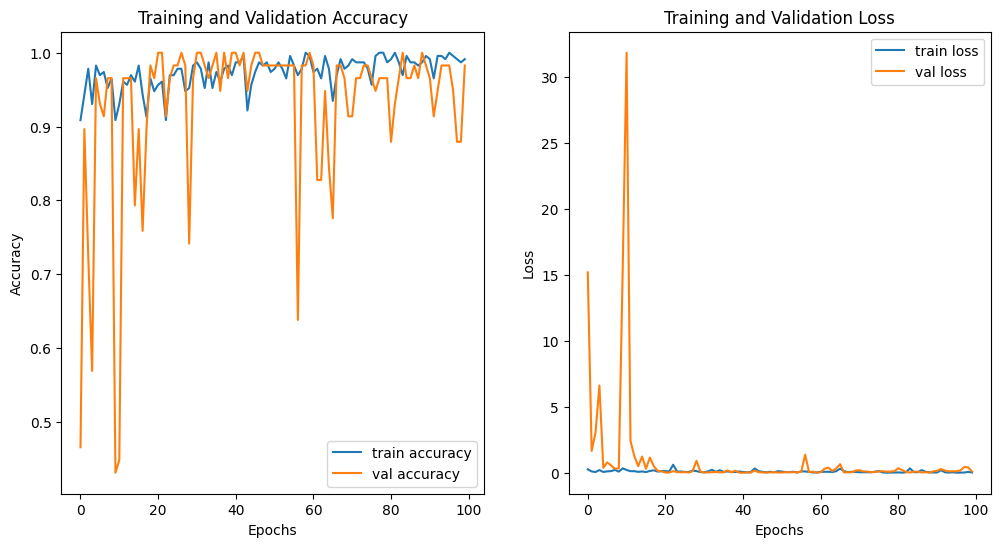

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 33s/step


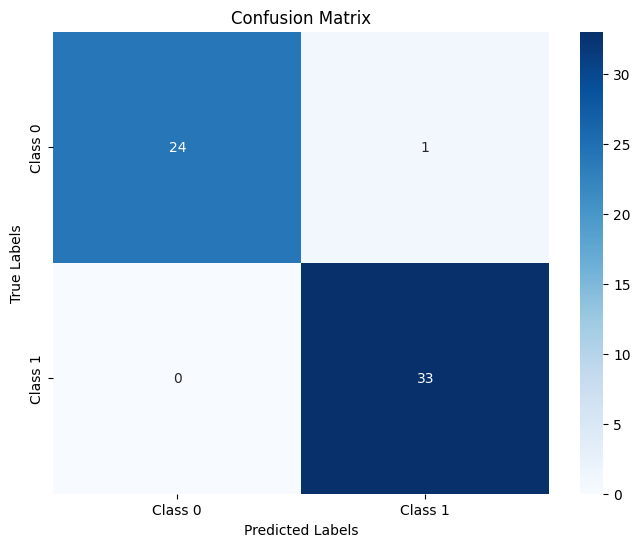

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.97      1.00      0.99        33

    accuracy                           0.98        58
   macro avg       0.99      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert one-hot encoded y_val to class indices if needed
y_val_classes = np.argmax(y_val, axis=1)

# Get the predictions
y_pred = model.predict(X_val)  # Predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class (for multi-class classification)

# Confusion Matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_val_classes, y_pred_classes)
print("Classification Report:")
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 768, 768, 3))
  warnings.warn(msg)


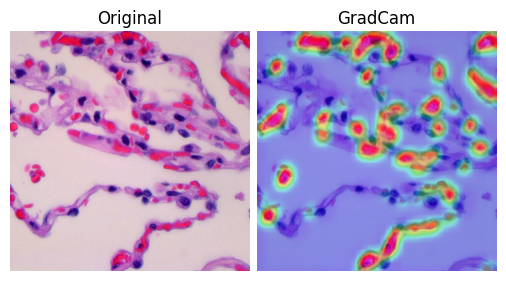

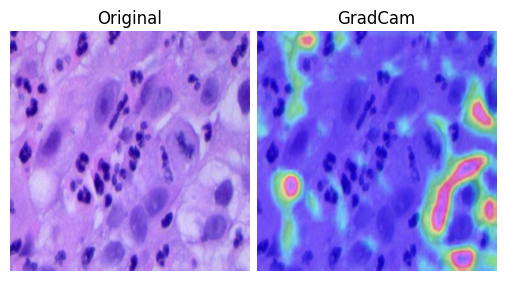

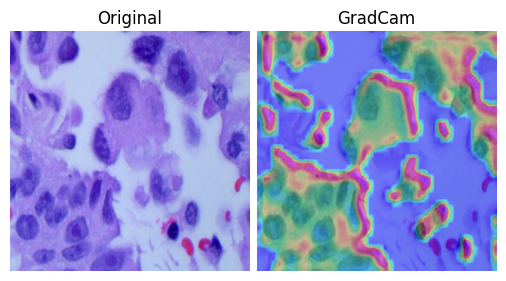

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random

# Function to generate Grad-CAM heatmap
def get_grad_cam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Predicted class index
        class_channel = predictions[:, pred_index]

    # Compute gradients of the predicted class w.r.t. last conv layer output
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Normalize heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_HSV):
    # Ensure the original image is in RGB format
    if len(img.shape) == 2 or img.shape[-1] == 1:  # Grayscale image
        img = cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Randomly select 3 images from test dataset
num_images = 3
last_conv_layer_name = 'conv2d_9'  # Replace with your model's last Conv2D layer
random_indices = random.sample(range(len(X_train)), num_images)

for i, idx in enumerate(random_indices):
    # Original test image
    original_img = X_train[idx]  # Shape: (50, 50, 1)
    img_array = np.expand_dims(original_img, axis=0)  # Add batch dimension

    # Generate Grad-CAM heatmap
    heatmap = get_grad_cam_heatmap(model, img_array, last_conv_layer_name)

    # Overlay heatmap on original image
    original_img = (original_img * 255).astype(np.uint8)  # Convert to 0-255 range
    heatmap_img = overlay_heatmap_on_image(original_img, heatmap)

    # Plot the results
    plt.figure(figsize=(5, 5))  # Keep small figure size to match 50x50 pixels

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img.squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Grad-CAM Heatmap Image
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_img)
    plt.title("GradCam")
    plt.axis('off')

    plt.tight_layout(pad=0.5)  # Adjust padding between plots
    plt.show()
